# Put the R in RAG

In [92]:
# Debug pinecone installation
!pip show pinecone

Name: pinecone
Version: 6.0.2
Summary: Pinecone client and SDK
Home-page: https://www.pinecone.io
Author: Pinecone Systems, Inc.
Author-email: support@pinecone.io
License: Apache-2.0
Location: c:\Users\kadda\github_repos\rag-gen-ai\.venv\Lib\site-packages
Requires: certifi, pinecone-plugin-interface, python-dateutil, typing-extensions, urllib3
Required-by: 


In [93]:
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
from bs4 import BeautifulSoup

import hashlib
import os
from dotenv import load_dotenv

from datetime import datetime

from tqdm import tqdm

In [94]:
load_dotenv()
# Retrieve the Pinecone API key from user data
pinecone_api_key = os.environ.get("PINECONE_API_KEY")

print(f"API key loaded: {pinecone_api_key[:3]}..." if pinecone_api_key else "No API key found")

# Initialize the OpenAI client
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# Define constants [vector size, embedding engine] small: 1536 medium: 4096 large: 12288
ENGINE = 'text-embedding-3-small'

# Initialize Pinecone client
pc = Pinecone(
    pinecone_api_key=pinecone_api_key
)

API key loaded: pcs...


In [95]:
INDEX_NAME = 'semantic-search-rag-index' # name of the collection of documents
NAMESPACE = 'default' # split the documents into namespaces. default is 'default'

def get_embeddings(text, engine=ENGINE):
    """
    Get the embeddings for a given text using OpenAI's API.
    """
    response = openai_client.embeddings.create(
            input=text,
            model=engine
        )
    return [data.embedding for data in list(response.data)]

def get_embedding(text, engine=ENGINE):
    """
    Get the embedding for a given text using OpenAI's API.
    Use the get_embeddings function to get the embedding for a single text
    """
    return get_embeddings(text, engine)[0]

len(get_embedding("Hello world!")), len(get_embeddings(["Hello world!", "Servus Welt"]))


(1536, 2)

In [96]:
if INDEX_NAME not in pc.list_indexes().names():
    # Create the index if it doesn't exist
    pc.create_index(
        name=INDEX_NAME, # name of the index
        dimension=1536, # dimension of the embedding for OpenAI's text-embedding-3-small
        metric='cosine', # metric for similarity search
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1',
        )
    )

# Store the index as variable
index = pc.Index(INDEX_NAME)
index

In [97]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 43}},
 'total_vector_count': 43,
 'vector_type': 'dense'}

In [98]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    # depending the vectorDB, We need to know how to upload the data to Pinecone and read
    # Compressed version of the text
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [99]:
def prepare_data_for_pinecone(texts, engine=ENGINE, urls=None):
    """
    Prepare the data for Pinecone by creating a list of tuples with the ID, embedding, and metadata.
    """

    now = datetime.now()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() 
    # function is used to generate the current UTC date and time
    responses = [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now.isoformat())  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]

    if urls and len(urls) == len(texts):
        for response, url in zip(responses, urls):
            response[-1]['url'] = url

    return responses
    

In [100]:
texts = ['hi']

In [101]:
_id, embedding, metadata = prepare_data_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2025-05-19T16:45:45.207929'}


In [102]:
urls = ['fake.url']
_id, embedding, metadata = prepare_data_for_pinecone(texts, urls=urls)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2025-05-19T16:45:45.933336', 'url': 'fake.url'}


In [103]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False, urls=None):
    # Call the prepare_data_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        text_batch = texts[i: i + batch_size]
        if urls:
            url_batch = urls[i: i + batch_size]
            prepared_texts = prepare_data_for_pinecone(text_batch, urls=url_batch)
        else:
            prepared_texts = prepare_data_for_pinecone(text_batch)


        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

In [104]:
# Call the upload_texts_to_pinecone() function with the input texts
upload_texts_to_pinecone(texts)

index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 44}},
 'total_vector_count': 44,
 'vector_type': 'dense'}

In [105]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [106]:
query_from_pinecone('hello')


[{'id': '49f68a5c8493ec2c0bf489821c21fc3b',
  'metadata': {'date_uploaded': '2025-05-19T16:45:46.217473', 'text': 'hi'},
  'score': 0.808450818,
  'values': []},
 {'id': '5e854f4638ce8ad012d67c38bb16ad4d',
  'metadata': {'date_uploaded': '2025-05-16T15:21:42.222583',
               'text': 'Suche Close Suchbegriff eingeben Suche Menü Close '
                       'Navigation Sprache Rathaus Zum Rathaus Politik und '
                       'Beteiligung Stadtverwaltung Presse und Medien Karriere '
                       'bei der Stadt Finanzen und Vergabe München im Portrait '
                       'Projekte und Initiativen Veranstaltungen Freizeit '
                       'Sehenswertes Verkehr Jobs Leben Bürgerservice Zu den '
                       'Services Wohnen und Meldewesen Verkehr und Mobilität '
                       'Ausland und Migration Gesundheit und Soziales Familie '
                       'und Kind Schule und Bildung Wirtschaft und Gewerbe '
                       'Br

In [107]:
def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

# delete our text
delete_texts_from_pinecone(texts)

{}

In [108]:
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 43}},
 'total_vector_count': 43,
 'vector_type': 'dense'}

In [109]:
# specific of the website strucutre munchen.de
# https://www.muenchen.de/en/events/
base_url = 'https://www.muenchen.de'
event_url = f'{base_url}/en/events/'
print(base_url)
print(event_url)

https://www.muenchen.de
https://www.muenchen.de/en/events/


In [110]:
import requests
import re

def find_links_with_pattern(url, pattern):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Compile the regex pattern
    regex = re.compile(pattern)
    
    # Find all 'a' tags with href attribute matching the pattern
    links = soup.find_all('a', href=regex)
    
    # Extract and return the href values
    return [link.get('href') for link in links]

# Example usage
pattern = r'^/en/node/'

matching_links = find_links_with_pattern(event_url, pattern)
len(matching_links)

16

In [111]:
urls = []

from bs4 import BeautifulSoup
import requests

for matching_link in tqdm(matching_links):
    full_link = base_url + matching_link
    r = requests.get(full_link)
    soup = BeautifulSoup(r.content, 'html.parser')
    for link in soup.find_all('a'):
        if 'href' in link.attrs:
            if link['href'].startswith('/') and 'sehenswuerdigkeiten' in link['href']:
                urls.append(base_url + link['href'])
    
urls = list(set([u.lower().strip() for u in urls]))
print(urls)
len(urls)

100%|██████████| 16/16 [00:43<00:00,  2.70s/it]

['https://www.muenchen.de/sehenswuerdigkeiten/museen/bayerische-staatsbibliothek', 'https://www.muenchen.de/sehenswuerdigkeiten/tourismus', 'https://www.muenchen.de/sehenswuerdigkeiten/webcam-live-aus-muenchen-marienplatz-olympiapark-und-mehr', 'https://www.muenchen.de/sehenswuerdigkeiten/museen/kunsthalle-muenchen', 'https://www.muenchen.de/sehenswuerdigkeiten/museen/zentralinstitut-fuer-kunstgeschichte', 'https://www.muenchen.de/sehenswuerdigkeiten/museen/museum-brandhorst', 'https://www.muenchen.de/sehenswuerdigkeiten/museen/archaeologische-staatssammlung', 'https://www.muenchen.de/sehenswuerdigkeiten/museen/galerie-bezirk-oberbayern', 'https://www.muenchen.de/sehenswuerdigkeiten/museen/juedisches-museum-muenchen', 'https://www.muenchen.de/sehenswuerdigkeiten/museen/infopoint-museen-schloesser-bayern', 'https://www.muenchen.de/sehenswuerdigkeiten/haus-der-kunst', 'https://www.muenchen.de/sehenswuerdigkeiten/museen/ns-dokumentationszentrum-muenchen']


12

In [112]:
for url in urls:
    print(url)

https://www.muenchen.de/sehenswuerdigkeiten/museen/bayerische-staatsbibliothek
https://www.muenchen.de/sehenswuerdigkeiten/tourismus
https://www.muenchen.de/sehenswuerdigkeiten/webcam-live-aus-muenchen-marienplatz-olympiapark-und-mehr
https://www.muenchen.de/sehenswuerdigkeiten/museen/kunsthalle-muenchen
https://www.muenchen.de/sehenswuerdigkeiten/museen/zentralinstitut-fuer-kunstgeschichte
https://www.muenchen.de/sehenswuerdigkeiten/museen/museum-brandhorst
https://www.muenchen.de/sehenswuerdigkeiten/museen/archaeologische-staatssammlung
https://www.muenchen.de/sehenswuerdigkeiten/museen/galerie-bezirk-oberbayern
https://www.muenchen.de/sehenswuerdigkeiten/museen/juedisches-museum-muenchen
https://www.muenchen.de/sehenswuerdigkeiten/museen/infopoint-museen-schloesser-bayern
https://www.muenchen.de/sehenswuerdigkeiten/haus-der-kunst
https://www.muenchen.de/sehenswuerdigkeiten/museen/ns-dokumentationszentrum-muenchen


In [113]:
import re

def clean_string(text):  # courtesy of Claude 3.5 Sonnet
    # Remove extra whitespace, including newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove any leading/trailing whitespace
    text = text.strip()
    # Remove common filler phrases
    filler_phrases = [
        "Skip to content", "Skip to main content", "Menu", "Sign in", "Print", "Views:", "Comments",
        "Footer menu", "Give us Feedback.", "Did this answer your question?", "No Yes No", "Thanks for your feedback.",
        "City Hall", "Events", "Culture, Leisure", "Restaurants", "Shopping", "Sights", "Tourism", 
        "Hotels", "Business", "Living", "Transportation", "Citizen service", "English", "Branchenbuch", 
        "Anzeige", "Search", "muenchen.de", "Das offizielle Stadtportal", "Home"
    ]
    for phrase in filler_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    # Remove any remaining brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    # Remove any remaining parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    # Remove any URLs
    text = re.sub(r'http\S+', '', text)
    # Remove any remaining special characters
    text = re.sub(r'[^\w\s\.\,\?\!]', '', text)
    # Remove extra spaces that may have been created
    text = re.sub(r'\s+', ' ', text).strip()
    print(text)
    return text

In [114]:
import requests

event_docs = []
for url in tqdm(urls):
    print(url)
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    # Find the main content container
    main_content = soup.find('main', id='content')

    if main_content:
        # Extract text from the main content area
        body_text = main_content.get_text(separator=' ', strip=True)
        # Clean the extracted text
        cleaned_text = clean_string(body_text)
        event_docs.append(dict(text=cleaned_text, url=url))
    else:
         print("No content found for URL:", url)

  0%|          | 0/12 [00:00<?, ?it/s]

https://www.muenchen.de/sehenswuerdigkeiten/museen/bayerische-staatsbibliothek


 25%|██▌       | 3/12 [00:02<00:05,  1.79it/s]

Stabi München Universalbibliothek mit kultureller Bedeutung Bayerische Staatsbibliothek Infos, Ausstellungen und Tipps Die Bayerische Staatsbibliothek ist die größte wissenschaftliche Universalbibliothek Deutschlands und das in historischem Ambiente. Adresse und Öffnungszeiten Ludwigstr. 16 , 80539 München Öffnungszeiten Mo geöffnet 0800 00 Mo 0800 00 Di 0800 00 Mi 0800 00 Do 0800 00 Fr 0800 00 Sa 0800 00 So 0800 00 Hinweis 2025 ist die Bibliothek an folgenden Tagen geschlossen 1. Januar 6. Januar 4. März 18. 21. April 1. Mai 29. Mai 8.9. Juni 19. Juni 15. August 3. Oktober 1. November 24. 26. Dezember 31. Dezember Anfahrt Bayerische Staatsbibliothek Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren In Kooperation mit dem Kulturreferat und den Museen Dieser Beitrag über die Münchner Museen wird vom Kulturreferat der Landeshauptstadt München gefördert und ist in Kooperation mit der Landesstelle für die nichtstaatlichen Museen in Bayern konzipiert worden. Die Inhalte wurd

 33%|███▎      | 4/12 [00:03<00:07,  1.12it/s]

Kunsthalle München Ein vielfältiges Kunstprogramm im Herzen der Stadt Kunsthalle München Ausstellungen aus Malerei, Fotografie und Design Drei bis vier Ausstellungen zeigt die international renommierte Kunsthalle in den Münchner Fünf Höfen jedes Jahr. Dabei werden alle Facetten der Kunst beleuchtet. Adresse und Öffnungszeiten Theatinerstr. 8 , 80333 München Öffnungszeiten Mo geöffnet 1000 2000 Mo 1000 2000 Di 1000 2000 Mi 1000 2000 Do 1000 2000 Fr 1000 2000 Sa 1000 2000 So 1000 2000 Hinweis An jedem dritten Mittwoch des Monats ist die Ausstellung zur Afterwork bis 22 Uhr geöffnet. Sonderöffnung für Schulklassen jeden Mittwoch von 910 Uhr Anfahrt Kunsthalle München Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Jeffrey Milstein Schaut euch Civilization an Von 11.04.24.8.25 folgt die Kunsthalle München den Spuren der Menschheit rund um den Globus aus dem Blickwinkel von über 100 international renommierten Fotografinnen. Erfahrt mehr Wissenswertes über einen Besuch in d

 42%|████▏     | 5/12 [00:05<00:08,  1.19s/it]

ZI Kunsthistorisches Forschungsinstitut und wissenschaftlicher Austausch Zentralinstitut für Kunstgeschichte München Infos zu Bibliothek und Photothek Das Zentralinstitut für Kunstgeschichte ist das einzige außeruniversitäre kunsthistorische Forschungsinstitut in Deutschland. Es beschäftigt sich mit der Geschichte der Kunst im globalen Kontext. Adresse und Öffnungszeiten KatharinavonBoraStr. 10 , 80333 München Öffnungszeiten Mo geöffnet 0900 2000 Mo 0900 2000 Di 0900 2000 Mi 0900 2000 Do 0900 2000 Fr 0900 2000 Sa geschlossen So geschlossen Hinweis Angegeben sind die Öffnungszeiten der Bibliothek Anfahrt Helena Heilig Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Zentralinstitut für Kunstgeschichte App MunichArtToGo Geht mit der neuen App des ZI auf eine interaktive Entdeckungsreise durch die Kunststadt München von 1800 bis heute. Mehr Infos zur App Warum lohnt sich ein Besuch im ZI in München? Gunnar Menzel Das Zentralinstitut für Kunstgeschichte hat seinen Sitz im 

 50%|█████     | 6/12 [00:06<00:07,  1.32s/it]

Museum Brandhorst Zeitgenössische Kunst in Münchens Zentrum Museum Brandhorst im Kunstareal Infos zu Ausstellung, Führung und Café In einem bunten Kunstbau mitten im Münchner Kunstareal präsentiert das Museum Brandhorst Werke zeitgenössischer Künstlerinnen, unter anderem von Andy Warhol und Cy Twombly. Adresse und Öffnungszeiten Theresienstr. 35a , 80333 München Öffnungszeiten geschlossen Mo geschlossen Di 1000 1800 Mi 1000 1800 Do 1000 2000 Fr 1000 1800 Sa 1000 1800 So 1000 1800 Hinweis An folgenden Feiertagen geschlossen Faschingsdienstag, Tag der Arbeit, Heiligabend, Erster Weihnachtstag, Silvester Anfahrt Andreas Lechtape, Museum Brandhorst Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im Museum Brandhorst? Museum Brandhorst Besucherinnen vor den Werken von Cy Twombly im Rosensaal des Museums Brandhorst Die spektakuläre MuseumsFassade aus 36.000 Keramikstäben kennt in München jeder doch was verbirgt sich dahinter? Was ist geboten? Im 

 58%|█████▊    | 7/12 [00:08<00:06,  1.30s/it]

Taucht ein in die Welt der Fundstücke und Ausgrabungen Archäologische Staatssammlung München Infos und Tipps zum Museum Eine Reise zurück in die Vergangenheit der menschlichen Existenz Nach etwa acht Jahren Bauzeit erstrahlt das Museum seit 2024 in neuem Glanz und präsentiert euch seine Exponate zu 120.000 Jahren bayerischer Siedlungsgeschichte. Adresse und Öffnungszeiten Lerchenfeldstr. 2 , 80538 München Öffnungszeiten geschlossen Mo geschlossen Di 1000 1700 Mi 1000 1700 Do 1000 1900 Fr 1000 1700 Sa 1000 1700 So 1000 1900 Hinweis Anfahrt ASM, Stefanie Friedrich Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Landesmuseum Württemberg, Hendrik Zwietasch Schaut euch die Sonderausstellung an Unter dem Titel Urformen Eiszeitkunst begreifen könnt ihr bis 21. April Repliken urzeitlicher Kunstwerke bewundern. Erfahrt mehr Warum lohnt sich ein Besuch in der Archäologischen Staatssammlung? Was ist geboten? Die Archäologische Staatssammlung ist in fünf Abteilungen untergliedert

 67%|██████▋   | 8/12 [00:10<00:06,  1.56s/it]

Galerie in der Prinzregentenstraße mit zeitgenössischer Kunst Galerie Bezirk Oberbayern Ausstellungen und Führungen In der Galerie Bezirk Oberbayern stellen Künstlerinnen mit und ohne Behinderung ihre Werke gemeinsam aus und gestalten ihre Ausstellung so, dass sie für alle zugänglich wird. Adresse und Öffnungszeiten Prinzregentenstr. 14 , 80538 München Öffnungszeiten Mo geöffnet 1000 1900 Mo 1000 1900 Di 1000 1900 Mi 1000 1900 Do 1000 1900 Fr 1000 1900 Sa geschlossen So geschlossen Hinweis Nach 18 Uhr bitte am Eingang klingeln. Feiertags geschlossen. Anfahrt Benjamin Schmidt Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch in der Galerie Bezirk Oberbayern? Bezirk Oberbayern Kunst inklusive! Die Galerie Bezirk Oberbayern macht Kunst für alle barrierefrei erlebbar. Was ist geboten? Es erwartet euch keine Dauerausstellung, sondern immer wieder neue Formate. Gezeigt werden zwei bis drei Doppelausstellungen pro Jahr, die Künstlerinnen mit und ohn

 75%|███████▌  | 9/12 [00:11<00:04,  1.58s/it]

Vielfalt jüdischer Kultur erleben Jüdisches Museum München Ausstellungen, Rundgänge, Programm Das Jüdische Museum München vermittelt ein Bild der Vielfalt jüdischer Geschichte, Kunst und Kultur von der Vergangenheit bis heute. Das Museum ist ein lebendiger Ort zum Austausch und zur offenen Diskussion. Adresse und Öffnungszeiten St.JakobsPlatz 16 , 80331 München Öffnungszeiten geschlossen Mo geschlossen Di 1000 1800 Mi 1000 1800 Do 1000 1800 Fr 1000 1800 Sa 1000 1800 So 1000 1800 Hinweis Anfahrt Daniel Schvarcz Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im Jüdischen Museum München? Roland Halbe Das kubische Gebäude des Jüdischen Museums München ist schon von Außen absolut sehenswert Im Jüdischen Museum München wird die Vielfalt jüdischer Zugänge in der Geschichte, Kultur und Kunst erfahrbar mit dem Ziel eine plurale und diskriminierungsfreie Gesellschaft zu ermöglichen. Was ist geboten? Das Museum vermittelt Einblicke in die jüdische Ku

 83%|████████▎ | 10/12 [00:13<00:03,  1.57s/it]

Information und Ideen für eure Museumsbesuche in München und Bayern Infopoint Museen Schlösser in Bayern Aktuelle AusstellungsTipps und Beratung Im Infopoint Museen Schlösser in Bayern erhalten Touristinnen und Einheimische aktuelle und umfassende Informationen über rund 1.300 Museen und Schlösser in Bayern. Adresse und Öffnungszeiten Alter Hof 1 , 80331 München Öffnungszeiten Mo geöffnet 1000 1800 Mo 1000 1800 Di 1000 1800 Mi 1000 1800 Do 1000 1800 Fr 1000 1800 Sa 1000 1800 So geschlossen Hinweis Sonn und Feiertags geschlossen Anfahrt Bayerisches Landesamt für DenkmalpflegeForstner Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch des Infopoints im Alten Hof? Museen in Bayern Ob Touristinnen oder Einheimische die Mitarbeiterinnen geben euch persönlich vor Ort, aber auch telefonisch und per EMail, Auskunft über alles, was zur Planung eines Ausflugs nützlich ist Was ist geboten? Informationen zu Öffnungszeiten, Adressen, Sonderausstellungen, F

 92%|█████████▏| 11/12 [00:15<00:01,  1.63s/it]

Zeitgenössische Kunst am Englischen Garten Das Haus der Kunst Haus der Kunst in München Aktuelle Ausstellungen, Tipps und Infos Es gehört zu den großen internationalen Kunstmuseen Das Haus der Kunst zeigt jährlich wechselnde Ausstellungen der Gegenwartskunst auf Weltniveau. Adresse und Öffnungszeiten Prinzregentenstr. 1 , 80538 München Öffnungszeiten Mo geöffnet 1000 2000 Mo 1000 2000 Di geschlossen Mi 1000 2000 Do 1000 2200 Fr 1000 2000 Sa 1000 2000 So 1000 2000 Hinweis Geschlossen 24. und 31. Dezember Anfahrt Haus der Kunst München, 2023, Foto Maximilian Geuter Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im Haus der Kunst? Haus der Kunst München, 2023, Foto Maximilian Geuter Das Haus der Kunst besitzt keine eigene Sammlung, es ist ein reines Ausstellungshaus. Und das ist seine große Stärke So hat es die Möglichkeit, den wechselnden Programmen viel Raum zu geben. Was ist geboten? Mit seinen Ausstellungen, Performances und Musikveransta

100%|██████████| 12/12 [00:16<00:00,  1.40s/it]

Lern und Erinnerungsort zur Geschichte des Nationalsozialismus NSDokumentationszentrum München Das NSDokumentationszentrum München ist der zentrale Ort zur Auseinandersetzung mit der nationalsozialistischen Vergangenheit der Stadt. Adresse und Öffnungszeiten MaxMannheimerPlatz 1 , 80333 München Öffnungszeiten geschlossen Mo geschlossen Di 1000 1900 Mi 1000 1900 Do 1000 1900 Fr 1000 1900 Sa 1000 1900 So 1000 1900 Hinweis An Feiertagen, die auf einen Montag fallen, hat das NSDokumentationszentrum geöffnet. Gesonderte Öffnungszeiten an Feiertagen. Anfahrt nsdoku Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren Warum lohnt sich ein Besuch im NSDokumentationszentrum München? Connolly Weber Die Dokumentation ist in inhaltliche Themenschwerpunkte gegliedert, die durch die Ausstellung leiten Das NSDokumentationszentrum München erinnert am historischen Ort an die Verbrechen der NSDiktatur und vermittelt die Geschichte des Nationalsozialismus mit Blick auf die Gegenwart und Zuku

In [115]:
event_docs[0]

{'text': 'Stabi München Universalbibliothek mit kultureller Bedeutung Bayerische Staatsbibliothek Infos, Ausstellungen und Tipps Die Bayerische Staatsbibliothek ist die größte wissenschaftliche Universalbibliothek Deutschlands und das in historischem Ambiente. Adresse und Öffnungszeiten Ludwigstr. 16 , 80539 München Öffnungszeiten Mo geöffnet 0800 00 Mo 0800 00 Di 0800 00 Mi 0800 00 Do 0800 00 Fr 0800 00 Sa 0800 00 So 0800 00 Hinweis 2025 ist die Bibliothek an folgenden Tagen geschlossen 1. Januar 6. Januar 4. März 18. 21. April 1. Mai 29. Mai 8.9. Juni 19. Juni 15. August 3. Oktober 1. November 24. 26. Dezember 31. Dezember Anfahrt Bayerische Staatsbibliothek Weitere Aktionen Teilen auf Facebook Teilen via WhatsApp Kopieren In Kooperation mit dem Kulturreferat und den Museen Dieser Beitrag über die Münchner Museen wird vom Kulturreferat der Landeshauptstadt München gefördert und ist in Kooperation mit der Landesstelle für die nichtstaatlichen Museen in Bayern konzipiert worden. Die In

In [116]:
BATCH_SIZE = 16
upload_texts_to_pinecone(
    texts=[g['text'] for g in event_docs],
    batch_size=BATCH_SIZE, show_progress_bar=True, 
    urls=[g['url'] for g in event_docs]
)

100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


12

In [117]:
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 44}},
 'total_vector_count': 44,
 'vector_type': 'dense'}

In [118]:
query = 'Ich will die Blaue Reiter bild von Franz Marc besuchen'

results = query_from_pinecone(query, top_k=10)
for result in results:
    print(result['metadata']['url'], result['score'], result['metadata']['text'][-50:])

https://www.muenchen.de/sehenswuerdigkeiten/museen/lenbachhaus-muenchen 0.509821773 Seite 1 Seite 2 Seite 3 Letzte Seite Nächste Seite
https://www.muenchen.de/sehenswuerdigkeiten/museen/lenbachhaus-muenchen 0.48386389 hauptstadt München und der Stadtwerke München GmbH
https://www.muenchen.de/sehenswuerdigkeiten/museen/lenbachhaus-muenchen 0.483780771 hauptstadt München und der Stadtwerke München GmbH
https://www.muenchen.de/sehenswuerdigkeiten/museen/museum-brandhorst 0.445284605 Seite 1 Seite 2 Seite 3 Letzte Seite Nächste Seite
https://www.muenchen.de/sehenswuerdigkeiten/museen/museum-brandhorst 0.428482056 hauptstadt München und der Stadtwerke München GmbH
https://www.muenchen.de/sehenswuerdigkeiten/museen/museum-brandhorst 0.428161621 hauptstadt München und der Stadtwerke München GmbH
https://www.muenchen.de/sehenswuerdigkeiten/haus-der-kunst 0.400598556 Seite 3 Seite 4 Seite 5 Letzte Seite Nächste Seite
https://www.muenchen.de/sehenswuerdigkeiten/museen/galerie-bezirk-oberbayern 0

## Using Open Source Embedders

In [119]:
from sentence_transformers import SentenceTransformer, util

open_source_embedder = SentenceTransformer('all-MiniLM-L6-v2')

open_source_embedder.encode(['hi', 'hello', 'sup']).shape

(3, 384)

In [120]:
open_source_embedder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

### Synthetci test data generation

In [121]:
synthetic_data_prompt = '''I am designing a chatbot to use this document as information to our users.

Please write 10 questions that an average person not living in Munich might ask that can definitely be answered using information using the provided document.

Try to ask in a way that's confusing to really test our system's knowledge but still fair.

I need 5 in german, 2 in english in that order.

Use this format to output:
Document: A given document to make questions from
JSON: ["german question 1", "german question 2", "german question 3", ...  "english question 1", "english question 2"]
###
Document: {document}
JSON:'''

response = openai_client.chat.completions.create(
    model='gpt-4o',
    messages=[{"role": "user", "content": synthetic_data_prompt.format(document=event_docs[1]['text'])}],
    temperature=1
)

In [122]:
languages = ['german']*5+['english']*2

In [123]:
import json

list(zip(
    languages,
    json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
))

[('german', 'Welche Museen in München sind besonders sehenswert?'),
 ('german', 'Gibt es Tipps für die LGBTIQ-Community in München?'),
 ('german',
  'Welche besonderen U-Bahn-Stationen sollte man in München besuchen?'),
 ('german', 'Welche Konzerthallen sollte man in München kennen?'),
 ('german', 'Was sind die Öffnungszeiten des Tierpark Hellabrunn?'),
 ('english',
  'What are some of the most notable landmarks to visit in Munich?'),
 ('english',
  'How can tourists get information about public transportation in Munich?')]

In [124]:
synthetic_questions = []
from random import sample

# generate synthetic test data for a sample  of the urls found
SAMPLE = .2
for i, event_doc in enumerate(tqdm(sample(event_docs, int(len(event_docs) * SAMPLE)))):
        
    response = openai_client.chat.completions.create(
        model='gpt-4o',
        messages=[{"role": "user", "content": synthetic_data_prompt.format(document=event_doc['text'])}],
        temperature=1
    )
    try:
        questions = json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
        questions = [q.strip() for q in questions]
        assert len(questions) == len(languages)
        for language, question in zip(languages, questions):
            synthetic_questions.append(
            dict(
                language=language, 
                query=question, 
                expected_hash=my_hash(event_doc['text'])
            )
        )
    except Exception as e:
        print(f'Could not generate questions for index {i}: {e}')

100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


In [125]:
len(synthetic_questions)

14

In [126]:
for q in synthetic_questions:
    print(f"[{q['language']}] {q['query']}")

[german] Welche Adresse hat die Kunsthalle München?
[german] Kann man in der Kunsthalle München eine Ausstellung länger als gewöhnlich besuchen, und wenn ja, wann?
[german] Was ist das Besondere an der Architektur der Kunsthalle München?
[german] Welche berühmten Künstler wurden in der Kunsthalle München schon ausgestellt?
[german] Gibt es in der Kunsthalle München ermäßigte Eintrittspreise, und wenn ja, wann?
[english] What is the recommended duration of a visit to the Kunsthalle München?
[english] How can one reach the Kunsthalle München using public transportation?
[german] Warum ist die Bayerische Staatsbibliothek für Forschende und Studierende von Bedeutung?
[german] Welche besonderen Sammlungen beherbergt die Bayerische Staatsbibliothek?
[german] Wie kann man die Bayerische Staatsbibliothek von der U-Bahn-Station Universität aus erreichen?
[german] Welche Historie hat das Gebäude der Bayerischen Staatsbibliothek?
[german] Wann ist die Bayerische Staatsbibliothek im Jahr 2025 gesc

In [127]:
def test_query(query, expected_hash, language, top_k=5):
        
    results = query_from_pinecone(query, top_k=top_k)
    top_result_correct = results[0]['id'] == expected_hash  # accuracy
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)  # Recall@top_k (10, etc)
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [128]:
test_query(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': False,
 'language': 'german',
 'expected_hash': '10d2d1855815617d864b41f6408cb86c',
 'top_hash': '5e854f4638ce8ad012d67c38bb16ad4d'}

In [129]:
synthetic_test_results = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results.append(test_query(**synthetic_question))

100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


result_in_pinecone_list    1.000000
top_result_correct         0.857143
dtype: float64


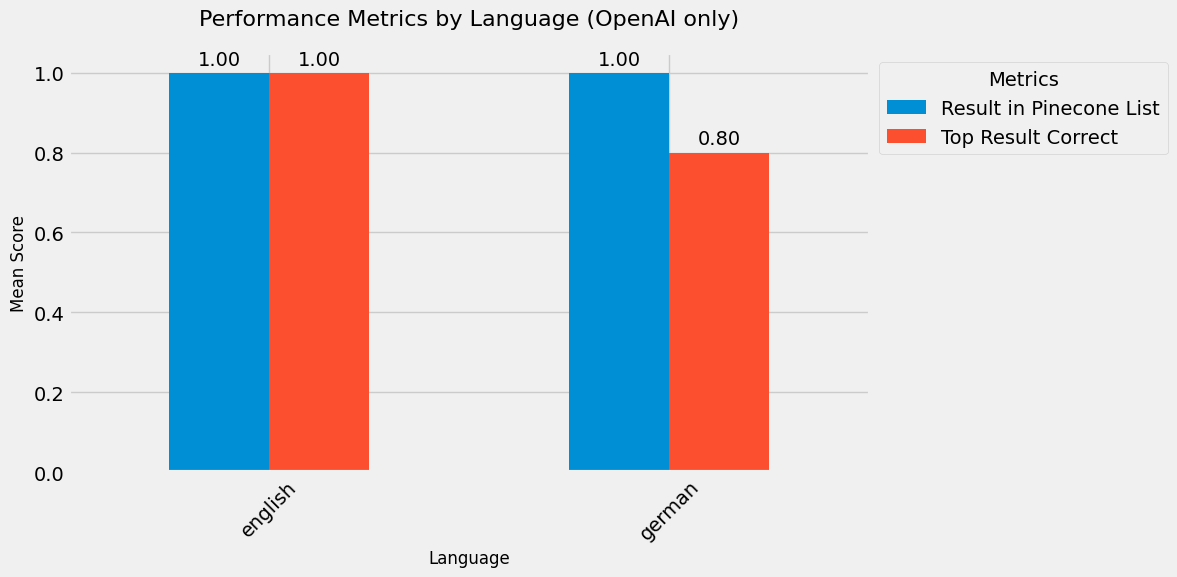

In [130]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results)

print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

import matplotlib.pyplot as plt

# Assuming you've already created results_df
grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')
# sns.set_palette("deep")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI only)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Making Retrieval Better with Cohere's Re-Rank

In [131]:
import cohere

load_dotenv()

co = cohere.Client(os.environ.get('COHERE_API_KEY'))